# Libraries

In [1]:
import numpy as np
from termcolor import colored

# Enviroment Traffic

In [2]:
# Reinforcement Learning Markov decission process
import random
from typing import Literal


class Traffic_Enviroment:
    def __init__(self, rows, columns) -> None:
        self.rows = rows
        self.columns = columns
        self.state = (1, 1)
        self.goal = (rows - 1, columns - 1)
        # streets matrix
        self.streets = np.full((rows, columns), -1)  # Initialize all cells as walls
        # generate streets
        self.generate_streets()

        # actions
        self.actions = ("u", "d", "l", "r")

        # states
        self.states = [(i, j) for i in range(rows) for j in range(columns)]

    moveAction = {
        "u": (-1, 0),
        "d": (1, 0),
        "l": (0, -1),
        "r": (0, 1),
    }

    def reset(self):
        self.state = (1, 1)

    def move(self, state: tuple[int, int], shift: tuple[int, int]):
        # validate boundaries
        if state[0] + shift[0] < 0 or state[0] + shift[0] >= self.rows or state[1] + shift[1] < 0 or state[1] + shift[1] >= self.columns:
            return state
        return (state[0] + shift[0], state[1] + shift[1])

    def reward(self, state: tuple[int, int], action: str):
        next_state = self.move(state, self.moveAction[action])
        if next_state == self.goal:
            return 0
        return -1

    def nextState(self, state: tuple[int, int], action: str):
        nextStates = {}
        next_state = self.move(state, self.moveAction[action])
        
        if next_state == self.goal:
            nextStates[self.goal] = 1.0
            return nextStates
    
        if self.streets[next_state] == 0:
            nextStates[self.state] = 1.0
            return nextStates

        # Probabilities
        
        if self.streets[self.state] == 1:
            nextStates[next_state] = 1.0
        elif self.streets[self.state] == 2:
            nextStates[next_state] = 0.65
            nextStates[self.state] = 0.35
           

        elif self.streets[self.state] == 3:
            nextStates[next_state] = 0.25
            nextStates[self.state] = 0.75
        else:
            nextStates[self.state] = 1.0
        
        return nextStates
    
    def simulateStep(self,state,action):
        reward = self.reward(state, action)
        nextStates = self.nextState(state, action)
        return random.choices( list( nextStates.keys() ), weights = list( nextStates.values() ), k=1 )[0], reward

    def step(self, action: Literal["u", "d", "l", "r"]):
        self.state, reward  = self.simulateStep(self.state, action)
        return self.state, reward

    # Generate streets
    # 0 = empty (not visited)
    # paths (1,2,3) -> choice randomly
    # houses (squares) -> -1
    def generate_streets(self):
        # Create a direct path from the initial state to the goal
        current = self.state
        while current != self.goal:
            self.streets[current] = 0  # Mark as part of the street
            next_step_choices = []
            if current[0] < self.goal[0]:
                next_step_choices.append((current[0] + 1, current[1]))
            if current[1] < self.goal[1]:
                next_step_choices.append((current[0], current[1] + 1))
            current = np.random.choice(range(len(next_step_choices)))
            current = next_step_choices[current]

        # Original random street generation process
        # Start with a random cell not including the direct path
        start_row, start_col = np.random.randint(1, self.rows - 1), np.random.randint(
            1, self.columns - 1
        )
        while self.streets[start_row, start_col] == 0:
            start_row, start_col = np.random.randint(
                1, self.rows - 1
            ), np.random.randint(1, self.columns - 1)
        self.streets[start_row, start_col] = 0
        frontiers = [(start_row, start_col)]

        while frontiers:
            current = frontiers.pop(np.random.randint(len(frontiers)))
            row, col = current
            self.streets[row, col] = 0  # Mark as part of the street

            neighbors = [(row + 1, col), (row - 1, col), (row, col + 1), (row, col - 1)]
            valid_neighbors = [
                n
                for n in neighbors
                if 0 <= n[0] < self.rows
                and 0 <= n[1] < self.columns
                and self.streets[n] == -1
            ]

            for n in valid_neighbors:
                self.streets[n] = 0  # Mark as part of the street
                frontiers.append(n)

        # Optionally, add paths with 1, 2, 3
        for i in range(self.rows):
            for j in range(self.columns):
                if self.streets[i, j] == 0:
                    self.streets[i, j] = np.random.choice([0, 1, 2, 3])

    # Render state, goal and numbers
    # -1  = *
    # use colored
    # 1 = color green
    # 2 = color yellow
    # 3 = color red
    def render(self):
        for i in range(self.rows):
            for j in range(self.columns):
                if self.state == (i, j):
                    print(colored("S", "blue"), end=" ")
                elif self.goal == (i, j):
                    print(colored("G", "blue"), end=" ")
                elif self.streets[i, j] == -1 or self.streets[i, j] == 0:
                    print(colored("*", "white"), end=" ")
                elif self.streets[i, j] == 1:
                    print(colored("1", "green"), end=" ")
                elif self.streets[i, j] == 2:
                    print(colored("2", "yellow"), end=" ")
                elif self.streets[i, j] == 3:
                    print(colored("3", "red"), end=" ")
            print()

# Policy Evaluation

In [3]:
import time
import numpy as np
from IPython.display import clear_output

def Simulate(env,maxSteps):
  env.reset()
  tempo = .25
  clear_output(wait=True)
  env.render()

  steps = 0

  while steps < maxSteps:

      breakSignal = False
      command = input("Write 'l', 'u', 'r', 'd' to move: ")
      for a in command:
        s = env.state
        if s == env.goal:
            breakSignal = True
            break
        if a in ['l', 'u', 'r', 'd']:
            env.step(a)
            steps += 1

        clear_output(wait=True)
        env.render()
        time.sleep(tempo)
      if env.state == env.goal or breakSignal:
        break

  if env.state == env.goal:
    print(f"Congratulations. You spent {steps} steps to reach the Goal.")
    input("Press enter to go to the next task.")
  else:
    print(f"You fail to reach the goal.")
    input("Press enter to go to the next task.")

  return steps

def EvaluatePolicyMC(env,policy,maxSteps,nSamples):

  memSteps = []
  memGoals = []

  for i in range(nSamples):
    env.reset()
    steps = 0

    while steps < maxSteps:
      s = env.state
      a = policy[s]
      if s == env.goal:
          break
      if a in ['l', 'u', 'r', 'd']:
          env.step(a)
          steps += 1

    if env.state == env.goal:
      memGoals = memGoals + [1]
      memSteps = memSteps + [steps]
    else:
      memGoals = memGoals + [0]


    clear_output(wait=True)
    print(f'Simulating {(i+1)/nSamples}')

  print(f'The goal was rechead {100*np.mean(memGoals)}% of the simulations.')
  if len(memSteps) > 0:
    print(f'The average steps in simulations that rechead the goal was {np.mean(memSteps)}.')

  return memSteps, memGoals

def SimulatePolicy(env,policy,maxSteps):
  env.reset()
  tempo = .25
  clear_output(wait=True)
  env.render()

  steps = 0

  while steps < maxSteps:
    s = env.state
    a = policy[s]
    if s == env.goal:
        break
    if a in ['l', 'u', 'r', 'd']:
        env.step(a)
        steps += 1

    clear_output(wait=True)
    env.render()
    time.sleep(tempo)
  if env.state == env.goal:
    print(f"Congratulations. You spent {steps} steps to reach the Goal.")
  else:
    print(f"You fail to reach the goal.")

  return steps

def SimulatePlan(env,plan):
  env.reset()
  tempo = .25
  clear_output(wait=True)
  env.render()

  steps = 0

  for a in plan:
    s = env.state
    if s == env.goal:
        break
    if a in ['l', 'u', 'r', 'd']:
        env.step(a)
        steps += 1

    clear_output(wait=True)
    env.render()
    time.sleep(tempo)
  if env.state == env.goal:
    print(f"Congratulations. You spent {steps} steps to reach the Goal.")
  else:
    print(f"You fail to reach the goal.")

  return steps

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def policy_evaluation(Environment,pi, gamma, epsilon, maxSamples = 1000):
    V = {}
    for s in Environment.states:
        V[s] = 0

    res = float('inf')

    resolution = 10;

    steps = 0

    while res > epsilon and steps < maxSamples:
        V_old = V.copy()
        res = 0

        for s in Environment.states:
            V[s] = Environment.reward(s,pi[s])
            Transitions = Environment.nextState(s,pi[s])
            for ss in Transitions:
                V[s] = V[s] + gamma*Transitions[ss]*V_old[ss]

            if abs(V[s] - V_old[s]) > res:
                res = abs(V[s] - V_old[s])


        steps += 1
        if steps % resolution == 0:
            clear_output(wait=True)
            print(f'Residual {res}')

    return V[Environment.state], V

def drawValues(env: Traffic_Enviroment,V):
    img = np.zeros((env.rows,env.columns))
    for i in range(env.rows):
      for j in range(env.columns):
        img[i-1,j-1] = V[(i,j)]
    plt.imshow(img, cmap='gray', vmin=min(V.values()), vmax=max(V.values()))
    plt.show()

In [5]:
def renderPolicy(env: Traffic_Enviroment, policy):
    print("")
    for i in range(env.rows):
        for j in range(env.columns):
            if policy[(i, j)] == "l":
                print("<", end="")
            elif policy[(i, j)] == "d":
                print("v", end="")
            elif policy[(i, j)] == "r":
                print(">", end="")
            elif policy[(i, j)] == "u":
                print("^", end="")
            else:
                print("*", end="")
        print("")

## Policy Iteration

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def policy_evaluation(Environment,pi, gamma, epsilon):
    V = {}
    for s in Environment.states:
        V[s] = 0

    res = float('inf')

    while res > epsilon:
        V_old = V.copy()
        res = 0

        for s in Environment.states:
            V[s] = Environment.reward(s,pi[s])
            Transitions = Environment.nextState(s,pi[s])
            for ss in Transitions:
                V[s] = V[s] + gamma*Transitions[ss]*V_old[ss]

            if abs(V[s] - V_old[s]) > res:
                res = abs(V[s] - V_old[s])

    return V

def policy_improvement(Environment,V, gamma):
    pi = {}
    for s in Environment.states:
        Q = {}
        for a in Environment.actions:
            Q[a] = Environment.reward(s,a)
            Transitions = Environment.nextState(s,a)
            for ss in Transitions:
                Q[a] = Q[a] + gamma*Transitions[ss]*V[ss]

        pi[s] = max(Q, key=Q.get)
    return pi

def policy_iteration(Environment, gamma, eps):

    res = 10

    policy = {}
    for s in Environment.states:
      policy[s] = 'r';

    V = policy_evaluation(Environment, policy, gamma, eps)

    renderPolicy(Environment,policy)

    while res > eps:
        policy = policy_improvement(Environment,V, gamma)
        V_old = V.copy()
        V = policy_evaluation(Environment, policy, gamma, eps)

        res = np.max(  np.abs( np.array(list(V.values())) -  np.array(list(V_old.values())) ) )

        print(f'Residual {res}')

        # clear_output(wait=True)
        renderPolicy(Environment,policy)

        print(f'O valor da política é {V[(1,1)]}.')
        print(f'O valor da política é {np.mean(list(V.values()))}.')

    return policy, V

In [7]:
gamma = 0.999
eps = 0.001
env = Traffic_Enviroment(20,20)

policy, V = policy_iteration(env,gamma,eps);


>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>
Residual 999.0016985804884

^v^^^^^^^^^^^^^^^^^^
>^<^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^vv
^^^^^^^^^^^^^^^^^>>v
O valor da política é -3.896165422342567.
O valor da política é -5.735608183293566.
Residual 2.8393129207413077

>vvv^>^^v^^<^<>^<^

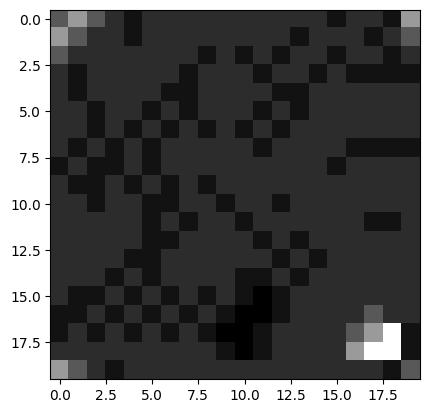

In [8]:
drawValues(env,V)

## Value Iteration

In [9]:
def value_iteration(Environment, gamma, eps):
    V = {}
    for s in Environment.states:
        V[s] = 0

    res = float("inf")

    if gamma < 1:
        epsilon = eps * (1 - gamma) / (2 * gamma)
    else:
        epsilon = eps

    while res > epsilon:
        V_old = V.copy()
        res = 0

        # 
        for s in Environment.states:
            Q = {}
            for a in Environment.actions:
                Q[a] = Environment.reward(s, a)
                Transitions = Environment.nextState(s, a)
                for ss in Transitions:
                    Q[a] = Q[a] + gamma * Transitions[ss] * V_old[ss]

            V[s] = max(Q.values())

            if abs(V[s] - V_old[s]) > res:
                res = abs(V[s] - V_old[s])

    #   Extrai a política epsilon-ótima
    # Extraer 
    pi = {}
    for s in Environment.states:
        Q = {}
        for a in Environment.actions:
            Q[a] = Environment.reward(s, a)
            Transitions = Environment.nextState(s, a)
            for ss in Transitions:
                Q[a] = Q[a] + gamma * Transitions[ss] * V[ss]

        pi[s] = max(Q, key=Q.get)

    return pi, V

In [10]:
gamma = 1
epsilon = 0.0001
env = Traffic_Enviroment(10,15)
policy, values = value_iteration(env,gamma, epsilon)
renderPolicy(env,policy)
print(f'O valor da política é {values[env.state]}.')


^vvvvvvvvv>vvvv
^vvvvvvvvvvvvvv
>>>vvvvvvvv>>>v
^^>>>>>>vvv^^>v
v>v^^^^vvvv<vvv
vvvvvv>vvvvvv>v
>>>>>v>>>>>vvvv
^^^^>>>^^^>>vvv
>^^>>^^^^^^>>vv
^^^^^^^^^^^^>>v
O valor da política é -20.0.


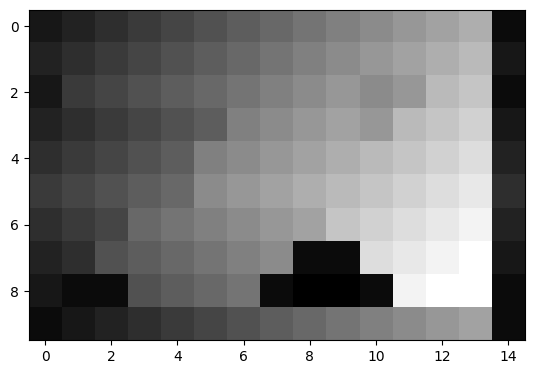

In [11]:
drawValues(env,values)

In [12]:
env.render()

* 3 1 2 * 2 2 * 2 * 2 3 * 3 1 
* S 1 2 2 2 1 3 1 1 * 1 3 3 3 
* 1 2 1 3 3 1 3 1 2 1 3 3 2 1 
* 3 * 2 1 3 2 2 2 1 2 2 1 * 2 
3 3 3 3 2 1 1 * 2 2 3 2 * * 1 
3 * 1 * 3 2 * 1 2 2 2 * 2 1 3 
1 2 3 3 1 2 * 2 2 2 2 1 3 * 3 
* 3 2 * * 1 2 2 1 * * 3 2 3 3 
2 3 * * 2 3 1 1 * 3 2 * 1 3 1 
1 3 3 1 * * * * 2 1 1 3 * 3 G 
